In [1]:
import polars as pl
pl.__version__  # The book is built with Polars version 1.20.0

'1.33.0'

# Polars Data Types and Missing Values

This notebook covers the fundamental data types in Polars, including nested types like Arrays, Lists, and Structs. 
It also dives deep into handling missing data (`null`) and special floating point values (`NaN`), as well as data type conversions.

# Polars Series, Dataframe, Lazyframe

Polars provides three main data structures:
- **Series**: A one-dimensional homogeneous array with a name.
- **DataFrame**: A two-dimensional table with named columns of potentially different types.
- **LazyFrame**: A representation of a query plan that hasn't been executed yet. It allows Polars to optimize queries before running them.

In [2]:
sales_series = pl.Series([150.00,300.00,250.00])

In [3]:
sales_df = pl.DataFrame(
    {
        "sales":sales_series,
        "customer_id":[24,25,26]
    }
)

In [4]:
sales_df

sales,customer_id
f64,i64
150.0,24
300.0,25
250.0,26


In [5]:
lazy_df = pl.scan_csv("data/fruit.csv").with_columns(is_heavy = pl.col("weight")>200)

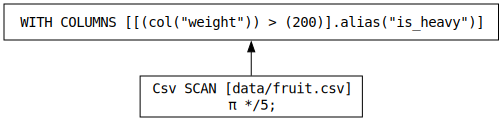

In [6]:
lazy_df.show_graph()

In [7]:
lazy_df.collect()

name,weight,color,is_round,origin,is_heavy
str,i64,str,bool,str,bool
"""Avocado""",200,"""green""",false,"""South America""",false
"""Banana""",120,"""yellow""",false,"""Asia""",false
"""Blueberry""",1,"""blue""",false,"""North America""",false
"""Cantaloupe""",2500,"""orange""",true,"""Africa""",true
"""Cranberry""",2,"""red""",false,"""North America""",false
"""Elderberry""",1,"""black""",false,"""Europe""",false
"""Orange""",130,"""orange""",true,"""Asia""",false
"""Papaya""",1000,"""orange""",false,"""South America""",true
"""Peach""",150,"""orange""",true,"""Asia""",false


## Polars Array

The `Array` data type in Polars represents **fixed-size** lists. 
Unlike the `List` type, `Array` enforces that every element has the same number of items. 
This allows for more memory-efficient storage and execution.

In [8]:
coordinates = pl.DataFrame(
    [
        pl.Series('point2d',[[1,3],[2,3]]),
        pl.Series('point3d',[[1,3,4],[4,5,6]]),
    ],
    schema={
        'point2d':pl.Array(shape=2, inner=pl.Int64),
        'point3d':pl.Array(shape=3, inner=pl.Int64),
    }
)


In [9]:
coordinates

point2d,point3d
"array[i64, 2]","array[i64, 3]"
"[1, 3]","[1, 3, 4]"
"[2, 3]","[4, 5, 6]"


## Polars List

The `List` data type allows for **variable-length** arrays within a column. 
This is useful for storing sequences of data, such as daily temperature readings or a list of tags.

In [10]:
weather_readings = pl.DataFrame(
{
"temperature": [[72.5, 75.0, 77.3], [68.0, 70.2]],
"wind_speed": [[15, 20], [10, 12, 14, 16]],
}
)
weather_readings

temperature,wind_speed
list[f64],list[i64]
"[72.5, 75.0, 77.3]","[15, 20]"
"[68.0, 70.2]","[10, 12, … 16]"


## Polars Struct

The `Struct` data type is similar to a dictionary or a row nested within a cell. 
It contains named fields, each with its own data type. Structs are useful for grouping related data together.

In [11]:
rating_series = pl.Series(
    "rating",[
        { "Movies":"Cars","Theater":"NE","Avg_rating":4.5},
        {"Movies":"Toy Story","Theater":"ME","Avg_rating":4.9},
    ],
)

In [12]:
rating_series

rating
struct[3]
"{""Cars"",""NE"",4.5}"
"{""Toy Story"",""ME"",4.9}"


## Missing Data

Missing data in Polars is represented by `null`. This is distinct from `NaN` (Not a Number). 
Polars provides extensive functionality to handle nulls, including filling them with specific values, strategies, or expressions.

### Missing single value, strategy and expresession

In [13]:
missing_df = pl.DataFrame(
{
"value": [None, 2, 3, 4, None, None, 7, 8, 9, None],
},
)

In [16]:
missing_df

value
i64
null
2
3
4
null
null
7
8
9


In [15]:
missing_df.null_count()

value
u32
4


In [20]:
missing_df.with_columns(single_value_fill = pl.col('value').fill_null(-1))

value,single_value_fill
i64,i64
null,-1
2,2
3,3
4,4
null,-1
null,-1
7,7
8,8
9,9


In [21]:
missing_df.with_columns(
    forward=pl.col("value").fill_null(strategy="forward"),
    backward=pl.col("value").fill_null(strategy="backward"),
    min=pl.col("value").fill_null(strategy="min"),
    max=pl.col("value").fill_null(strategy="max"),
    mean=pl.col("value").fill_null(strategy="mean"),
    zero=pl.col("value").fill_null(strategy="zero"),
    one=pl.col("value").fill_null(strategy="one"),
)

value,forward,backward,min,max,mean,zero,one
i64,i64,i64,i64,i64,i64,i64,i64
null,null,2,2,9,5,0,1
2,2,2,2,2,2,2,2
3,3,3,3,3,3,3,3
4,4,4,4,4,4,4,4
null,4,7,2,9,5,0,1
null,4,7,2,9,5,0,1
7,7,7,7,7,7,7,7
8,8,8,8,8,8,8,8
9,9,9,9,9,9,9,9


In [22]:
missing_df.with_columns(
expression_mean=pl.col("value").fill_null(pl.col("value").mean())
)

value,expression_mean
i64,f64
null,5.5
2,2.0
3,3.0
4,4.0
null,5.5
null,5.5
7,7.0
8,8.0
9,9.0


In [23]:
missing_df.interpolate()

value
f64
null
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


# NULL vs Not a Number (NaN)

It is crucial to distinguish between `null` and `NaN`:
- **`null`**: Represents missing data. It applies to all data types.
- **`NaN` (Not a Number)**: A special floating-point value representing undefined results (e.g., 0/0). It only applies to floating-point columns.

Polars handles them differently. `null` is ignored in aggregations (like mean), while `NaN` propagates (NaN + 1 = NaN).

In [ ]:
import numpy as np

nan_df = pl.DataFrame({
    "value": [1.0, np.nan, None, 4.0]
})
print(nan_df)

You can check for these values using `is_nan()` and `is_null()`.

In [ ]:
nan_df.with_columns(
    is_nan = pl.col("value").is_nan(),
    is_null = pl.col("value").is_null()
)

To handle `NaN` values, you can use `fill_nan()`. Note that `fill_null()` does NOT affect `NaN` values.

In [ ]:
nan_df.with_columns(
    filled_nan = pl.col("value").fill_nan(0.0),
    filled_null = pl.col("value").fill_null(0.0)
)

# Data Type Conversion

Changing data types (casting) is a common operation. Polars uses the `.cast()` method.
By default, casting is **strict**. If a value cannot be converted (e.g., casting "abc" to Integer), Polars will raise an error.

In [24]:
string_df = pl.DataFrame({"id": ["10000", "20000", "30000"]})
print(string_df)
print(f"Estimated size: {string_df.estimated_size('b')} bytes")

shape: (3, 1)
┌───────┐
│ id    │
│ ---   │
│ str   │
╞═══════╡
│ 10000 │
│ 20000 │
│ 30000 │
└───────┘
Estimated size: 15 bytes


In [27]:
string_df_int = string_df.select(pl.col("id").cast(pl.UInt16))

In [28]:
print(f"Estimated size: {string_df_int.estimated_size('b')} bytes")

Estimated size: 6 bytes


In [29]:
data_types_df = pl.DataFrame(
{
"id": [10000, 20000, 30000],
"value": [1.0, 2.0, 3.0],
"value2": ["1", "2", "3"],
}
)

In [30]:
data_types_df

id,value,value2
i64,f64,str
10000,1.0,"""1"""
20000,2.0,"""2"""
30000,3.0,"""3"""


In [31]:
data_types_df.cast(pl.UInt16)

id,value,value2
u16,u16,u16
10000,1,1
20000,2,2
30000,3,3


In [32]:
data_types_df.cast({"id": pl.UInt16, "value": pl.Float32, "value2": pl.UInt8})

id,value,value2
u16,f32,u8
10000,1.0,1
20000,2.0,2
30000,3.0,3


In [33]:
data_types_df.cast({pl.Float64: pl.Float32, pl.String: pl.UInt8})

id,value,value2
i64,f32,u8
10000,1.0,1
20000,2.0,2
30000,3.0,3


In [34]:
import polars.selectors as cs

In [35]:
data_types_df.cast({cs.numeric():pl.UInt16})

id,value,value2
u16,u16,str
10000,1,"""1"""
20000,2,"""2"""
30000,3,"""3"""


### Strict vs Non-Strict Casting
You can disable strict mode to convert failing casts into `null` values instead of raising an error.

In [ ]:
strict_df = pl.DataFrame({"val": ["1", "2", "a"]})

# This would raise an error:
# strict_df.select(pl.col("val").cast(pl.Int64))

# Non-strict casting replaces errors with null:
strict_df.select(pl.col("val").cast(pl.Int64, strict=False))